# Classificação de Imagens

## Abordar o problema e Analisar o Panorama Geral

A classificação de imagens é a tarefa de atribuir a uma imagem de entrada um rótulo de um conjunto finito de categorias. Este é um dos problemas centrais da visão computacional que, apesar de sua simplicidade, possui uma variedade de aplicações práticas.

Neste artigo, iremos classificar imagens de raio x do tórax de diversos pacientes para determinar se a imagem é referente a um paciente que está com pneumonia ou não.

<center><img src="https://github.com/vitorbeltrao/Pictures/blob/main/IM-0005-0001.jpeg?raw=true" width="25%"></center>

Esse modelo classificador que iremos criar, será muito útil e importante para médicos e radiologistas, visto que o mesmo poderá auxilia-los nessa tarefa de diagnosticar um paciente com pneumonia ou não, ajudando-os a tomar decisões muito mais rápidas e assertivas.

Tecnicamente falando, iremos abordar o problema com aprendizado supervisionado. Iremos utilizar as redes neurais para a tarefa de classificação, caso você não esteja muito confortável com algoritmos envolvendo redes neurais, durante o processo irei explicando detalhadamente como funciona. A nível de desempenho do algoritmo, vamos utilizar a matriz de confusão, precisão e recall, ao longo do processo também falaremos mais sobre essas métricas.

## Obter os Dados

Os dados desse trabalho, foram obtidos pelo [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). Lá temos esse e outros conjuntos de dados muito úteis! 

In [1]:
# Instalar bibliotecas necessárias
!pip install opencv-python

In [2]:
# Instalar bibliotecas necessárias
!pip install tensorflow

In [3]:
# Importar bibliotecas necessárias
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
import cv2
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path
import os.path
import glob
from time import perf_counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [4]:
# Leitura dos dados das imagens e transforma-las para um formato adequado
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Remodelar imagens para o tamanho preferido
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
# Divisão do conjunto de dados em treino, validação e teste
train = get_training_data('train')
test = get_training_data('test')
val = get_training_data('val')

## Análise Exploratória dos Dados

Aqui, a ideia é explorar mais a fundo todo o conjunto de dados de treino.

Tamanho da lista: 5216
Quantidade de rótulos "Pneumonia": 3875
Quantidade de rótulos "Normal": 1341


[]

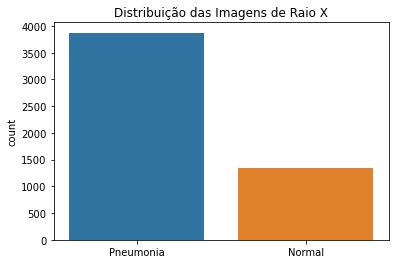

In [6]:
# Colocar imagens em uma lista e rotula-las em "pneumonia" e "normal"
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

# Plotar gráfico de barras para análise da distribuição dos rótulos
print('Tamanho da lista:', len(l))
print('Quantidade de rótulos "Pneumonia":', l.count('Pneumonia'))
print('Quantidade de rótulos "Normal":', l.count('Normal'))

fig, ax = plt.subplots()
sns.countplot(l)
ax.set_title('Distribuição das Imagens de Raio X')
plt.plot()

Vemos que o conjunto de dados está um pouco desbalanceado e posteriormente vamos corrigir esse problema, mas antes vamos dar uma olhada nas imagens de cada rótulo.

Text(0.5, 1.0, 'NORMAL')

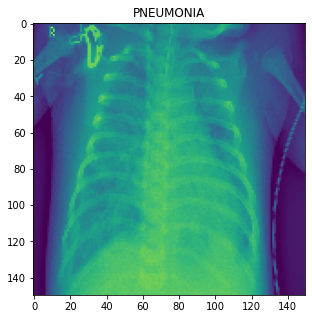

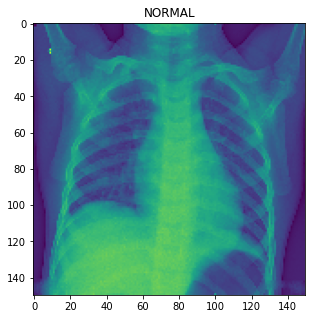

In [7]:
# Plot das imagens de cada rótulo
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='viridis')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='viridis')
plt.title(labels[train[-1][1]])

Interessante não é mesmo? Vamos seguir para a próxima etapa e começar o pré-processamento dos dados para alimentarmos nosso modelo

## Pré Processamento dos dados

### Dividindo o conjunto de dados

Agora, com base nos dados que ingerimos, é hora de distribuí-los nos respectivos grupos de treinamento, teste e validação.

In [8]:
# Separando o conjunto de dados em X/y
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

x_val = []
y_val = []    

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

x_test = []
y_test = []    
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

### Normalização das Imagens

Os valores de pixel podem variar de 0 a 256. Cada número representa um código de cor. Ao usar uma imagem como esta e passar por uma rede neural, o cálculo de valores numéricos altos pode se tornar mais complexo. Para reduzir isso, podemos normalizar os valores para variar de 0 a 1.

Dessa forma, os números serão pequenos e a computação se tornará mais fácil e rápida. Como os valores de pixel variam de 0 a 256, o intervalo é de 255, portanto, dividir todos os valores por 255 o converterá em um intervalo de 0 a 1.

In [9]:
# Normalizando os dados
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
# Redimensionar as imagens para ficarem no padrão correto
X_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

### Data Augmentation

O desempenho de um modelo está diretamente ligado a qualidade e quantidade de dados. Muitas vezes, mesmo após a utilização de um modelo adequado, não obtemos resultados satisfatórios. Ter um grande conjunto de dados é crucial para o desempenho do modelo de deep learning, no entanto, podemos não ter a quantidade e diversidade de dados que desejamos para treinar o modelo para um requisito personalizado, prejudicando seu desempenho.

Nesse caso, como obter mais dados se não temos "mais dados"? É aqui que essa etapa entra em cena!

> O aumento de dados é uma técnica para criar artificialmente novos dados de treinamento a partir de dados de treinamento existentes. Isso é feito aplicando técnicas específicas de domínio a exemplos dos dados de treinamento que criam exemplos de treinamento novos e diferentes.

<center><img src="https://github.com/vitorbeltrao/Pictures/blob/main/data_augmentation.png?raw=true" width="25%"></center>

Isso nos ajuda a aumentar o tamanho e introduzir variabilidade no conjunto de dados, sem realmente coletar novos dados. A rede neural trata essas imagens como imagens distintas e ainda ajusta a reduzir o overfitting. As alterações nas imagens existentes para aumentar o número de instâncias podem ser: rotacionar/virar a imagem em todos os sentidos, saturar, aumentar o brilho, centralizar o recorte e por ai vai. Consulte a biblioteca do [TensorFlow](https://www.tensorflow.org/tutorials/images/data_augmentation) para mais informações.

In [11]:
# Aumento de dados
data_generator = ImageDataGenerator(
        featurewise_center=False,  # defina a média de entrada para 0 no conjunto de dados
        samplewise_center=False,  # defina cada média amostral para 0
        featurewise_std_normalization=False,  # dividir entradas por desvio-padrão do conjunto de dados
        samplewise_std_normalization=False,  # divida cada entrada por seu desvio-padrão
        zca_whitening=False,  # aplique o clareamento ZCA
        rotation_range = 30,  # girar imagens aleatoriamente no intervalo (graus, 0 a 180)
        zoom_range = 0.1, # Zoom aleatório na imagem 
        width_shift_range=0.1,  # deslocar aleatoriamente imagens horizontalmente (fração da largura total)
        height_shift_range=0.1,  # deslocar aleatoriamente imagens verticalmente (fração da altura total)
        horizontal_flip = True,  # virar imagens aleatoriamente
        vertical_flip=False)  # virar imagens aleatoriamente

# treinar apenas com os dados de treinamento
data_generator.fit(X_train)

Para o aumento de dados, selecionei as seguintes técnicas:

1. Girar aleatoriamente algumas imagens 30 graus
2. Ampliar aleatoriamente em 10% algumas imagens
3. Deslocar aleatoriamente as imagens na horizontal em 10% da largura
4. Deslocar aleatoriamente as imagens na vertical em 10% da altura
5. Virar as imagens aleatoriamente na horizontal

## Criar a Rede Neural

### Perceptron Multicamadas e Retropropagação

Uma MLP (MultiLayer Perceptron) é composta de uma **camada de entrada** (passagem), uma ou mais camadas de TLUs (Unidade Lógica de Limiar), chamadas de **camadas ocultas**, e uma camada final de TLUs, chamada de **camada de saída**.

As camadas próximas a camada de entrada normalmente se chamam **camadas inferiores** e as próximas as saídas se chamam **camadas superiores**. Cada camada, tirando a camada de saída, inclui um neurônio de viés e está totalmente conectada a próxima camada.

<center><img src="https://github.com/vitorbeltrao/Pictures/blob/main/Rede_neural.png?raw=true" width="25%"></center>

> Unidade Lógica de Limiar: um neurônio artificial que calcula uma soma ponderada de suas entradas e aplica uma função de ativação.

**Vamos analisar esse algoritmo mais detalhadamente:**

* Ele manipula um mini-batch por vez (por exemplo, contendo 32 instâncias cada) e realiza o treinamento completo diversas vezes. Cada passagem é chamada de *época (epoch)*.

* Cada mini-batch é passado para a camada de entrada da rede, que a envia para a primeira camada oculta. O algoritmo calcula a saída de todos os neurônios nesta camada (para todas as intâncias do mini-batch). O resultado é passado para a próxima camada, sua saída é calculada e passada para a próxima camada, e assim sucessivamente até obtermos a saída da última camada, **a camada de saída**. Esse que descrevemos agora é o chamado **forward pass**: é justamente como efetuar as predições, exceto que todos os resultados intermediários são preservado, pois, são necessários para o **backward pass**.

* Em seguida, o algoritmo calcula o erro de saída da rede (ou seja, usa uma função de perda que compara a saída desejada e a saída real da rede e retorna alguma medida de erro).

* Depois, ele calcula o quanto cada conexão de saída contribuiu para o erro. Esse proceso é feito analiticamente aplicando a **regra da cadeia**, o que torna essa etapa rápida e precisa.

* O algoritmo calcula quanto dessas contribuições de erro veio de cada conexão na camada inferior, usando mais uma vez a regra da cadeia, trabalhando em backward até o algoritmo atingir a camada de entrada. Essa passagem reversa computa com eficiência o gradiente de erro em todos os pesos de conexão da rede, retropropagando o gradiente de erro.

* Por último, o algoritmo executa uma etapa do gradiente descendente para ajustar todos os pesos de conexão na rede, utilizando os gradientes de erro que acabou de calcular.

**Resumindo:** para cada instância de treinamento, o algoritmo de retropropagação primeiro faz uma predição (forward pass) e calcula o erro, depois passa por cada camada no sentido inverso a fim de calcular a contribuição do erro de cada conexão (backward pass) e, por fim, ajusta os pesos da conexão para reduzir o erro (etapa do gradiente descendente).

> É importante inicializar todos os pesos de conexão das camadas ocultas aleatoriamente ou o treinamento irá por água abaixo.

Vamos colocar a mão na massa? O nosso caso, se trata de uma classificação binária (Pneumomia ou Normal). Vamos fazer uma tabela para tentar generalizar arquiteturas de uma MLP de classificação.

<center><img src="https://github.com/vitorbeltrao/Pictures/blob/main/arq_tipica_mlp_classificacao.png?raw=true" width="55%"></center>

Visto essas arquiteturas típicas, vamos ao modelo!

#### 1° Modelo - MLP Usando a Sequential API

In [12]:
# 1a Etapa - Instanciar a MLP usando a sequential API
model = keras.models.Sequential([ # cria modelo sequential
    keras.layers.Flatten(input_shape=[150,150,1]), # 1a camada flatten
    keras.layers.Dense(300, activation='relu'), # 1a camada oculta dense
    keras.layers.Dense(100, activation='relu'), # 2a camada oculta dense
    keras.layers.Dense(1, activation='sigmoid')  # camada de saída dense
])

**Vamos analisar esse código linha por linha:**

* A primeira linha cria um modelo *sequential*. É o tipo mais simples de modelo Keras para redes neurais contituídas somente de uma única pilha de camadas sequencialmente conectadas. Isso se chama API sequancial.

* Em seguida, criamos a primeira camada e a adicionamos ao modelo. É uma camada *flatten* cujo papel é converter cada imagem de entrada em uma matriz 1D. Essa camada não tem nenhum parâmetro e está lá somente para fazer um simples pré-processamento.

* Depois adicionamos uma camada oculta *dense* com 300 neurônios. Ela utilizará a função de ativação *relu*. Cada camada *dense* se encarrega da sua própria matriz de peso, que contém todos os pesos de conexão entre os neurônios e suas entradas. Ela também gerencia um vetor de *bias* (um por neurônio).

* Depois adicionamos uma segunda camada oculta *dense* com 100 neurônios, usando também a função de ativação *relu*.

* Por último, adicionamos uma camada de saída *dense* com 1 neurônio (1 por classe), usando a função de ativação *sigmoid*.

In [13]:
# Ver sumário do modelo antes de compilar
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               6750300   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 6,780,501
Trainable params: 6,780,501
Non-trainable params: 0
_________________________________________________________________


O método summary do modelo exibe todas as camadas do modelo.

In [14]:
# Atribuir primeira camada oculta a uma variável
hidden1 = model.layers[1]

# Acessar os parâmetros de cada camada
weights, biases = hidden1.get_weights() # acessando pesos e bias da primeira camada oculta
print(weights, weights.shape)
print('\n', biases, biases.shape)

[[-1.27711641e-02  6.64103962e-03  2.04771757e-03 ... -6.45025168e-03
  -4.24163602e-03 -9.84299742e-03]
 [-1.08658653e-02 -8.07604101e-03 -8.91650654e-03 ...  5.69851324e-03
   5.41104190e-03 -1.50717180e-02]
 [-1.20229106e-02 -1.10030323e-02 -1.16697699e-02 ... -8.00526328e-03
  -7.41387066e-03 -3.59494705e-03]
 ...
 [ 1.22400951e-02  2.79529020e-03  1.66111439e-03 ...  9.26570222e-03
   1.24389939e-02 -1.13524254e-02]
 [-5.48084918e-03  1.39730275e-02  7.85735995e-03 ... -1.03318468e-02
   1.00349151e-02 -5.64968772e-03]
 [ 3.13464552e-05  1.56874433e-02  7.54282624e-03 ... -1.35955941e-02
  -6.51817117e-03  1.72274932e-03]] (22500, 300)

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Todos os parâmetros de uma camada podem ser acessados por meio de seus métodos *get_weights* e *set_weights*. Para uma camada *dense*, isso inclui os pesos de conexão e os vieses.

***

Após a criação de um modelo, você deve chamar seu método *compile* para especificar a função de perda e o otimizador a ser usado. Como opção, você pode especificar uma lista de métricas extras a serem calculadas durante o treinamento e avaliação

In [15]:
# 2a Etapa - Compilando o modelo
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [16]:
# 3a etapa treinando e avaliando o modelo

# usar funções callbacks para salvar modelo em intervalos regulares
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5',
                                                save_best_only=True) # salvará apenas o melhor modelo

# implementar também a earlystopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

# combinamos as duas formas de callbacks para salvar pontos de verificação do modelo e interromper o treinamento
# com antecedência, quando não houver mais progresso

# treinar e avaliar o modelo
history = model.fit(data_generator.flow(X_train, y_train), epochs=100,
                    validation_data=data_generator.flow(X_val, y_val), # é possível já passar o conjunto de validação no método fit
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
163/163 [==============================] - 13s 74ms/step - loss: 0.5464 - accuracy: 0.7398 - val_loss: 0.8471 - val_accuracy: 0.5000
Epoch 2/100
163/163 [==============================] - 12s 73ms/step - loss: 0.4702 - accuracy: 0.7849 - val_loss: 0.8364 - val_accuracy: 0.5625
Epoch 3/100
163/163 [==============================] - 12s 73ms/step - loss: 0.4378 - accuracy: 0.7998 - val_loss: 1.1565 - val_accuracy: 0.5625
Epoch 4/100
163/163 [==============================] - 12s 76ms/step - loss: 0.4016 - accuracy: 0.8194 - val_loss: 0.7651 - val_accuracy: 0.6250
Epoch 5/100
163/163 [==============================] - 14s 86ms/step - loss: 0.3858 - accuracy: 0.8319 - val_loss: 0.8254 - val_accuracy: 0.5625
Epoch 6/100
163/163 [==============================] - 12s 76ms/step - loss: 0.3673 - accuracy: 0.8365 - val_loss: 0.7926 - val_accuracy: 0.5625
Epoch 7/100
163/163 [==============================] - 12s 74ms/step - loss: 0.3599 - accuracy: 0.8401 - val_loss: 0.7483 - val_ac

> Em vez de passar um conjunto de validação utilizando o argumento *validation_data*, é possível definir *validation_split* em relação a proporção do conjunto de treinamento que você deseja que a Keras use para validação. Por exemplo, o *validation_split=0.1* informa a Keras para usar os últimos 10% dos dados (antes de embaralhá-los) para validação.

Se o conjunto de treinamento estiver muito assimétrico, com algumas classes sendo representadas em excesso e outras sendo representadas de menos, seria útil definir o argumento *class_weight* ao chamar o método *fit*, que daria um peso maior as classes menos representadas e um peso menor as classes representadas em excesso.

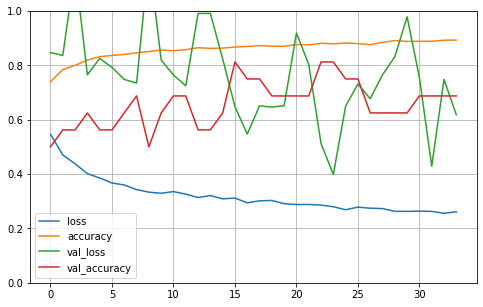

In [17]:
# curvas de aprendizado
learning_curves = pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### 2° Modelo - Usando uma CNN

Para essa tarefa, o uso das CNNs são mais adequadas do que as MLPs. Mas porque simplesmente não usar uma MLP com camadas totalmente conectadas para tarefas de reconhecimento de imagem? Infelizmente, embora isso funcione bem para imagens pequenas, não funciona bem para imagens maiores devido ao grande número de parâmetros que se exige. As CNNs solucionam esse problema usando camadas parcialmente conectadas e compartilhamento de peso.

As típicas arquiteturas das CNNs empilham algumas camadas convolucionais (cada uma geralmente seguida por uma camada ReLU), depois uma camada de pooling, depois outras camadas convolucionais (+ ReLU), depois outra camada de pooling e assim sucessivamente. A imagem fica cada vez menor a medida que avança pela rede, mas também fica cada vez mais profunda (ou seja, com mais mapas de características), graças as camadas convolucionais. No topo da pilha, uma rede neural do tipo feedforward é adicionada, composta de algumas camadas totalmente interligadas (+ ReLUs), e a camada final gera uma predição de saída (por exemplo, uma camada softmax que gera probabilidades de classe estimadas como saída).

<center><img src="https://github.com/vitorbeltrao/Pictures/blob/main/tipica_arquitetura_CNN.png?raw=true" width="55%"></center>

In [18]:
# # 1a etapa - implementação da CNN
# cnn_model = keras.models.Sequential([
#     keras.layers.Conv2D(64, 7, strides=1, activation="relu", padding="same", input_shape=[150,150,1]), # camada convolucional de entrada
#     keras.layers.MaxPooling2D(2), # camada de pooling
    
#     keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
#     keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
#     keras.layers.MaxPooling2D(2),
    
#     keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
#     keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
#     keras.layers.MaxPooling2D(2),
    
#     keras.layers.Flatten(),
#     keras.layers.Dense(128, activation="relu"),
#     keras.layers.Dropout(0.5),
    
#     keras.layers.Dense(64, activation="relu"),
#     keras.layers.Dropout(0.5),
    
#     keras.layers.Dense(1, activation='sigmoid')  # camada de saída dense
# ])

**Vamos analisar detalhadamente esse modelo:**

* A primeira camada usa 64 filtros bem grandes (7x7) e um stride de 1. Define também *input_shape=[150,150,1]*, pois as imagens tem 150x150 pixels.
* Em seguida, temos uma camada máxima de pooling que usa um tamanho de pool de 2, então ela divide cada dimensão espacial por um fator de 2.
* Depois, repetimos a mesma estrutura duas vezes: duas camadas convolucionais seguida por uma camada máxima de pooling. Para imagens maiores, poderíamos repetir essa estrutura diversas vezes (o número de repetições é um hiperparâmetro que você pode ajustar).
* Observe que o número de filtros aumenta a medida que escalamos a CNN em direção a camada de saída (inicialmente é 64, depois 128, depois 256): faz todo sentido esse aumento, já que o número de características de nível inferior é frequentemente muito baixo (por exemplo, pequenos círculos, linhas horizontais); mas existem diversas maneiras diferentes de combinar características de nível superior. É uma prática comum dobrar o número de filtros após cada camada de pooling: uma vez que uma camada de pooling divide cada dimensão espacial por um fator de 2, podemos dobrar o número de mapas de características na próxima camada sem medo de explodir o número de parâmetros, o uso de memória ou carga computacional.
* A seguir temos a rede totalmente conectada, composta de duas camadas densas ocultas e uma camada densa de saída. Repare que devemos achatar suas entradas, uma vez que uma rede densa espera um array 1D de características para cada instância. Adicionamos também duas camadas de dropout, com uma taxa de dropout de 50% cada, para reduzir o overfitting.

In [19]:
# # 2a Etapa - Compilando o modelo
# cnn_model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

In [20]:
# # 3a etapa treinando e avaliando o modelo

# # usar funções callbacks para salvar modelo em intervalos regulares
# checkpoint_cb = keras.callbacks.ModelCheckpoint('my_cnn_model.h5',
#                                                 save_best_only=True) # salvará apenas o melhor modelo

# # implementar também a earlystopping
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
#                                                   restore_best_weights=True)

# # combinamos as duas formas de callbacks para salvar pontos de verificação do modelo e interromper o treinamento
# # com antecedência, quando não houver mais progresso

# # treinar e avaliar o modelo
# cnn_history = cnn_model.fit(data_generator.flow(X_train, y_train), epochs=10,
#                             validation_data=data_generator.flow(X_val, y_val), # é possível já passar o conjunto de validação no método fit
#                             callbacks=[checkpoint_cb, early_stopping_cb])

In [21]:
# # curvas de aprendizado
# learning_curves = pd.DataFrame(cnn_history.history).plot(figsize=(8, 5))
# plt.grid(True)
# plt.gca().set_ylim(0, 1)
# plt.show()

O treinamento da CNN, é muito lento para a capacidade computacional que eu possuo. Precisaríamos treinar com mais epochs e fazer uma otimização de hiperparâmetros. Devido a essa falta de capacidade computacional, vamos tentar outro método.

#### 3° Modelo - Aprendizado por transferência

Podemos reutilizar modelos com arquiteturas pré-existentes. Vamos testar diversos modelos e arquiteturas disponíveis na *tensorflow*.

In [22]:
# IMG_SIZE = 224
# BATCH = 32
# SEED = 42

In [23]:
# train_path = os.path.join("train")
# test_path=os.path.join("test")

# train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
# train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

# test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
# test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [24]:
# train_list = [x for x in train_normal]
# train_list.extend([x for x in train_pneumonia])

# df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
# df_train['image'] = [x for x in train_list]

# test_list = [x for x in test_normal]
# test_list.extend([x for x in test_pneumonia])

# df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
# df_test['image'] = [x for x in test_list]

In [25]:
# def create_gen():
#     # Load the Images with a generator and Data Augmentation
#     train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#         preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
#         validation_split=0.1
#     )

#     test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#         preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
#     )

#     train_images = train_generator.flow_from_dataframe(
#         dataframe=df_train,
#         x_col='image',
#         y_col='class',
#         target_size=(224, 224),
#         color_mode='rgb',
#         class_mode='categorical',
#         batch_size=32,
#         shuffle=True,
#         seed=0,
#         subset='training',
# #         rotation_range=30, # Uncomment to use data augmentation
# #         zoom_range=0.15,
# #         width_shift_range=0.2,
# #         height_shift_range=0.2,
# #         shear_range=0.15,
# #         horizontal_flip=True,
# #         fill_mode="nearest"
#     )

#     val_images = train_generator.flow_from_dataframe(
#         dataframe=df_train,
#         x_col='image',
#         y_col='class',
#         target_size=(224, 224),
#         color_mode='rgb',
#         class_mode='categorical',
#         batch_size=32,
#         shuffle=True,
#         seed=0,
#         subset='validation',
# #         rotation_range=30, # Uncomment to use data augmentation on the validation set
# #         zoom_range=0.15,
# #         width_shift_range=0.2,
# #         height_shift_range=0.2,
# #         shear_range=0.15,
# #         horizontal_flip=True,
# #         fill_mode="nearest"
#     )

#     test_images = test_generator.flow_from_dataframe(
#         dataframe=df_test,
#         x_col='image',
#         y_col='class',
#         target_size=(224, 224),
#         color_mode='rgb',
#         class_mode='categorical',
#         batch_size=32,
#         shuffle=False
#     )
    
#     return train_generator,test_generator,train_images,val_images,test_images

In [26]:
# def get_model(model):
# # Load the pretained model
#     kwargs =    {'input_shape':(224, 224, 3),
#                 'include_top':False,
#                 'weights':'imagenet',
#                 'pooling':'avg'}
    
#     pretrained_model = model(**kwargs)
#     pretrained_model.trainable = False
    
#     inputs = pretrained_model.input

#     x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)

#     outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
    
#     return model

In [27]:
# # Dictionary with the models
# models = {
# #     "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
# #     "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
# #     "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
# #     "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
# #     "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
# #     "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
# #     "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
# #     "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
# #     "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
# #     "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
# #     "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
# #     "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
# #     "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
# #     "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
# #     "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
# #     "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
# #     "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
# #     "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
# #     "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
# #     "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
# #     "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
# #     "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
# #     "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
#     "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
#     "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
#     "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
#     "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
#     "Xception": {"model":tf.keras.applications.Xception, "perf":0}
# }

# # Create the generators
# train_generator,test_generator,train_images,val_images,test_images=create_gen()
# print('\n')

# # Fit the models
# for name, model in models.items():
    
#     # Get the model
#     m = get_model(model['model'])
#     models[name]['model'] = m
    
#     start = perf_counter()
    
#     # Fit the model
#     history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
#     # Sav the duration and the val_accuracy
#     duration = perf_counter() - start
#     duration = round(duration,2)
#     models[name]['perf'] = duration
#     print(f"{name:20} trained in {duration} sec")
    
#     val_acc = history.history['val_accuracy']
#     models[name]['val_acc'] = [round(v,4) for v in val_acc]

In [28]:
# for name, model in models.items():
    
#     # Predict the label of the test_images
#     pred = models[name]['model'].predict(test_images)
#     pred = np.argmax(pred,axis=1)

#     # Map the label
#     labels = (train_images.class_indices)
#     labels = dict((v,k) for k,v in labels.items())
#     pred = [labels[k] for k in pred]

#     y_test = list(df_test['class'])
#     acc = accuracy_score(y_test,pred)
#     models[name]['acc'] = round(acc,4)

In [29]:
# # Create a DataFrame with the results
# models_result = []

# for name, v in models.items():
#     models_result.append([name, models[name]['val_acc'][-1], 
#                           models[name]['acc'],
#                           models[name]['perf']])
    
# df_results = pd.DataFrame(models_result, 
#                           columns = ['model','val_accuracy','accuracy (test set)','Training time (sec)'])
# df_results.sort_values(by='accuracy (test set)', ascending=False, inplace=True)
# df_results.reset_index(inplace=True,drop=True)
# df_results

In [30]:
# plt.figure(figsize = (15,5))
# sns.barplot(x = 'model', y = 'accuracy (test set)', data = df_results)
# plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
# plt.ylim(0,1)
# plt.xticks(rotation=90)
# plt.show()

In [31]:
# plt.figure(figsize = (15,5))
# sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
# plt.title('Training time for each model in sec', fontsize = 15)
# plt.xticks(rotation=90)
# plt.show()

In [32]:
# acc = df_results.iloc[0]['accuracy (test set)']
# best_model = df_results.iloc[0]['model']
# print(f'# Best model: {best_model}')
# print(f'# Accuracy on the test set: {acc * 100:.2f}%')

In [33]:
# # Predict the labels of the test_images for the best model
# final_model = df_results.iloc[1]['model']
# pred = models[final_model]['model'].predict(test_images)
# pred = np.argmax(pred,axis=1)

# # Map the label
# labels = (train_images.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# pred = [labels[k] for k in pred]

# y_test = list(df_test['class'])
# acc = accuracy_score(y_test,pred)
# models[name]['acc'] = round(acc,4)

In [34]:
# # Display a confusion matrix
# cf_matrix = confusion_matrix(y_test, pred, normalize='true')
# plt.figure(figsize = (8,6))
# sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
# plt.title('Normalized Confusion Matrix\n', fontsize = 23)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()

In [35]:
# print(classification_report(y_test,pred))

## Otimizar os Hiperparâmetros

A flexibilidade das redes neurais também é um de seus principais empecilhos: existem muitos hiperparâmetros para ajustar. Aqui utilizaremos o *RandomizedSearchCV*.

Para fazer isso, é necessário empacotarmos nossos modelos Keras em objetos que imitem os regressores/classificadores regulares da Scikit-Learn. O primeiro passo é criar uma função que construirá e compilará um modelo Keras, levando em conta um conjunto de hiperparâmetros:

In [36]:
# Função que empacota nosso modelo Keras para imitar a scikit learn
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[150,150,1]):
    '''
    '''
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[150,150,1]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

In [37]:
# criaremos classificador keras com base na função 'build_model()'
keras_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [42]:
# Aplicando as transformações de pré-processamento nos nossos dados de treino
X_train_aug1 = np.copy(X_train)
y_train_aug1 = np.copy(y_train)
for i, img in enumerate(X_train):
    tmp = img.reshape(-1, img_size, img_size, 1)
    t_iter = data_generator.flow(tmp, batch_size=1)
    X_train_aug1[i] = next(t_iter)[0]

In [44]:
# otimizar hiperparâmetros
# definir os hiperparâmetros que vamos testar
param_distribs = {
    'n_hidden': [1, 2, 3],
    'n_neurons': np.arange(100, 300),
    'learning_rate': reciprocal(3e-4, 3e-2),
}

# instanciar o randomizedsearch
rnd_search_cv = RandomizedSearchCV(keras_classifier, param_distribs, n_iter=10, cv=3, scoring='accuracy', error_score='raise')

# treinar e avaliar o modelo
rnd_search_cv.fit(X_train_aug1, y_train_aug1, epochs=100,
                  validation_data=data_generator.flow(X_val, y_val), # é possível já passar o conjunto de validação no método fit
                  callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
109/109 [==============================] - 4s 34ms/step - loss: 0.6252 - val_loss: 0.7191
Epoch 2/100
109/109 [==============================] - 4s 38ms/step - loss: 0.5783 - val_loss: 0.6657
Epoch 3/100
109/109 [==============================] - 3s 28ms/step - loss: 0.5486 - val_loss: 0.6733
Epoch 4/100
109/109 [==============================] - 3s 27ms/step - loss: 0.5256 - val_loss: 0.6838
Epoch 5/100
109/109 [==============================] - 3s 29ms/step - loss: 0.5059 - val_loss: 0.5628
Epoch 6/100
109/109 [==============================] - 3s 28ms/step - loss: 0.4897 - val_loss: 0.7138
Epoch 7/100
109/109 [==============================] - 3s 30ms/step - loss: 0.4779 - val_loss: 0.6441
Epoch 8/100
109/109 [==============================] - 3s 25ms/step - loss: 0.4681 - val_loss: 0.6651
Epoch 9/100
109/109 [==============================] - 3s 26ms/step - loss: 0.4551 - val_loss: 0.6920
Epoch 10/100
109/109 [==============================] - 3s 25ms/step - loss: 0.449

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002B68BC00820>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B68C6CE190>,
                                        'n_hidden': [1, 2, 3],
                                        'n_neurons': array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114...
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255,
       256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
       282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294,
       295, 296, 297, 298, 299])},
                   scoring='accuracy')

In [45]:
# buscar pelo melhor modelo
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
final_model = rnd_search_cv.best_estimator_.model

{'learning_rate': 0.0010524334918571054, 'n_hidden': 1, 'n_neurons': 120}
0.6922040298016597


Agora, você pode salvar esse modelo, avaliá-lo no conjunto de testes e, se ficar satisfeito com seu desempenho, implementá-lo em produção.

## Salvando e Armazendo um Modelo

Ao usar a sequential API é muito fácil salvar um modelos Keras treinado.

In [46]:
# salvando o modelo
final_model.save('my_keras_model.h5')

## Avaliação do Modelo no Conjunto de Teste

In [52]:
# Avaliando o modelo no conjunto de testes final
X_new = X_test[:5]
y_pred = final_model.predict_classes(X_new)
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [53]:
np.array(y_test)[y_pred]

array([[0],
       [0],
       [0],
       [0],
       [0]])

De fato, para as primeiras 5 imagens do conjunto de teste, nosso modelo as preveu corretamente. Vamos analisar algumas métricas.

In [54]:
# Vamos plotar a report classification para todas as instâncias do conjunto de teste
y_pred = final_model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.87      0.83      0.85       390
   Normal (Class 1)       0.74      0.80      0.77       234

           accuracy                           0.82       624
          macro avg       0.81      0.82      0.81       624
       weighted avg       0.82      0.82      0.82       624



<AxesSubplot:>

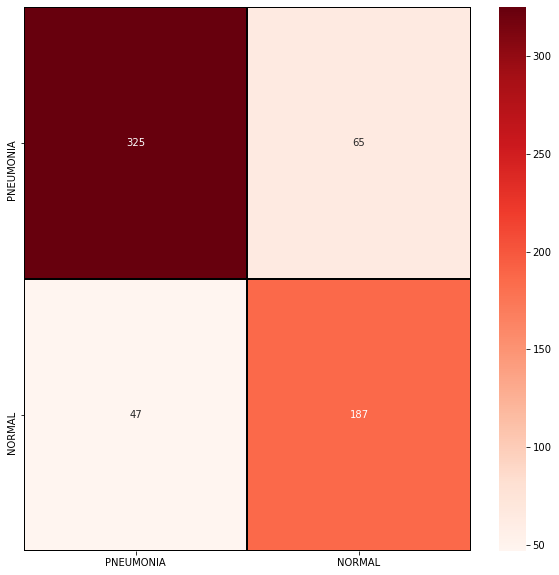

In [55]:
# matriz de confusão
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

## Conclusão

Para problemas de visão computacional, utilizar as CNNs são mais adequadas e certamente irão atingir desempenhos melhores que os nossos aqui. Nosso modelo não obteve um desempenho tão bom, mas para uma primeira iteração ficou razoável! Podemos deixar como próximos passos, abordar esse problema com as CNNs e comparar os respectivos desempenhos das duas arquiteturas. Podemos também, além de testar a nossa própria CNN, testar diversas arquiteturas de modelos pré-treinados com o **aprendizado por transferência**.

Acabamos sofrendo um pouco com o problema do overfitting, onde o nosso modelo se saia melhor no conjunto de dados de treinamento do que no conjunto de dados de validação, mas é de se esperar, visto que esse é um problema complexo. No fim, acabamos atingindo uma acurácia de 82% no conjunto de testes, o que como falamos, não está nada mal para uma primeira iteração.

Para finalizar, vamos resumir todas as etapas do projeto:

1. Analisar o panorama geral - Entendendo o problema do negócio;
2. Obter os dados;
3. Análise Exploratória dos dados;
4. Pré-processamento dos dados;
5. Criar e treinar uma MLP;
6. Aperfeiçoar o modelo;
7. Avaliação do modelo no conjunto de teste e apresentar a solução.